## Covid Patients Chest X-Ray Image Interpretation

### Problem Statement
* While RT-PCR testing as the standard test for COVID-19 detection, it is a very time-consuming, laborious, and complicated manual process. Besides studies show that there are high chances of getting a False Positive with RT-PCR. To make this detection faster, Group 2 tries to build a Deep Convolutional Neural Network which will predict the presence of Coronavirus using the patient’s chest x-ray image, so that only patients with a Positive result can be taken further for an RT-PCR test.
    
    
    
* **Keywords:** RT-PCR, COVID-19, False Positive, chest x-ray image, Deep Convolutional Neural Network
	

### Data Collection
* Source(url): http://ictcf.biocuckoo.cn/HUST-19.php
* Short Description : The data set of iCTCF is an open resource dataset that contains chest computed tomography (CT) from 1170 patients. We are provided with 19,685 manually labeled CT slices. The labeling splits them into 3 categories; non-informative CT (NiCT), positive CT (pCT), negative CT (nCT).
* The 19,685 labeled CT slices consist of 5705 NiCT, 4001 pCT, and 9979 nCT.
* NiCT slices are scans where the lung parenchyma was not captured. Therefore not allowing the medical profesisonals to discern Covid-19 Pneumonia.
* pCT slices are scans where imaging features associated with COVID-19 pneumonia could be clearly discerned.
* nCT slices are scans where imaging features were not associated with COVID-19 pneumonia.
* This dataset plays a major role in our goal to predict COVID-19 pneumonia using CT scans. We are able to use this labeled data to train our model to discern between CTs that show positive COVID-19 pneumonia features and also negatives ones. Moreover, this dataset allows us to also train our model to detect CTs that it should not predict COVID-19 pneumonia on when there isn't enough information on the CT scan or it is an incomplete CT scan. This is an important addition to our model, as it is important to know when not to make predictions, especially in the medical field when the stakes are very high.

* Keywords: COVID-19, computed tomography, CT, non-informative CT, NiCT, positive CT, pCT, negative CT, nCT.

### Required packages

* Please make sure you install any of the following packages that you are missing.


In [7]:
## Your code begins here

# Import all the needed packages
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

# We also import pretrained models that will be used in our model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import VGG19

### Data Preprocessing


In [3]:
## Your code begins here

# We start by loading the images and labels
# First step consists of getting the path to our data and shuffling the paths in order to avoid our model becoming 
# biased to the order the images are loaded in. We set a seed for the shuffle to be reproduced by others.
imagePaths = sorted(list(paths.list_images(r"C:\Users\fadyn\Desktop\Penn_State_Coursework\SPRING_2021\Deep_Learning\Project\Data\Data")))
random.seed(97)
random.shuffle(imagePaths)

# Initialize data and labels
data = []
labels = []

# We load all the images into memory and resize them to 64x64 pixels to not overwhelm our GPU and memory. And extract the label
# for each image from its path
width = 64 
height = 64
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (width, height))
    data.append(image)
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# We also scale the pixels to become between 0 and 1 and create an array of both the images data and the labels
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Another important part of our data preprocessing consists of data augmentation. This allows us to improve the performance of
# our networks by providing them with artificially created new training data. For image data augmentation, this involves the 
# random flips, zooms, rotations. To try an cover more of the possible variations that images can be seen in.
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


### Methodology

1. Explain your Deep Learning process / methodology
    * In this project, we are going to use convolutional neural networks (CNN or ConvNet). This deep learning architecture could be labeled as one of the most popular ones out there. Even though this architecture style has been around since the late 90s when introduced by Yann LeCun, it only grew in popularity around 2012 with the introduction of AlexNet. Since then, we have seen the emergence of many models that build deeper and more complex CNN architectures while increasing the accuracy outputs, especially during the ImageNet Large Scale Visual Recognition Challenge which gave birth to many state of the art models that are used nowadays in image classification and that we will use in our own project. CNN models are very powerful as they are able to learn distinguished features of each label (category) of an image.
    * In our case, we opted to start by setting up a simple CNN to set up a baseline to improve upon. As our goal is to match the state of the art result that Wanshan Ning[1] was able to achieve 99% accuracy in his co-authored paper about prediction of COVID-19 pneumonia via deep learning.
    

2. Introduce the Deep Neural Networks you used in your project
 * General
    * All our ConvNets will be configured to take an input shape of (64, 64, 3). We format our images this way, because of the limitations of our resources. In the future, with access to more powerful computational resources, we can increase the resolution of our images. But for now, any major increase in the resolution of our images would result in out of memory problems because of the size of our dataset and how deep ad rich in parameters some of our networks are.
    * All of our ConvNet models will be flattened to be fed into a densely-connected network that has a few dense layers and a final activation layer "softmax" for a multiclass classification (NiCT, nCT, pCT).
 * Model 1
    * We first decided to set up a simple CNN model that will serve as a baseline. It consists of 6 layers of stacked Conv2D and MaxPooling2D. We then flatten it to set up our fully connect layers.
    * This model is very small in comparison to the state of the art models that are out there. We only have 1,053,795 trainable parameters.
    * We can see below the limitations of this model during its evaluation.
 
 * Model 2
    * The second model that we build is inspired from the VGG19 architecture. This architecture is popular because of its high performance on the imagenet dataset competition. However, it does come with its limitation. It is heavier and requires longer training time as it has a large number of parameters to train.
    * We are able to get high accuracy performance with this model. However, we believe the training time to accuracy tradeoff is not worth it.
    
  * Model 3
    * The third model we use relies on transfer training. We import the DenseNet121 model using keras. The DenseNet121 architecture has been shown to perform well on chest X-rays in Rajpurkar co-authored paper Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning. This model allows us to save on time and get comparable accuracy to the VGG19 model we ran previously.
    * When we try an add a few dense layers into this model, it ends up underperforming in comparison to just running it with its original architecture. It is very hard to modify the structure of a model to get better results when the model already performs at 99% accuracy without any modifications.

   * Unshown models
     * We also ran a few transfer training models using ResNet50, InceptionV3, VGG16 for testing purposes and to compare their performance to our other models. These models are not show here to not increase the time it would take to run this jupyter notebook. The difference in performance with our used models was marginal, except for VGG16 which underperformed heavily.
 
 * Future Models
     * We would like to take this project further by combining clinical data about the patients with their computed tomography to predict severity of COVID-19 infection (mild, normal ,severe, critical). This will allows us to go beyond just diagnosing an individual as COVID-19 positive or negative. It would allow us to create a system that can help prioritize and redirect medical resources based on the severity of cases and their distribution around the region.



**Keywords:** convolutional neural network, CNN, ConvNet, VGG19, DenseNet121, ResNet50, InceptionV3, VGG16

### Model Fitting and Validation

  * We fit and validate all models on our train and validation data that is partionined below.
  * We use the Adam optimizer as it is a combination of both AdaGrad and RMSProp. It is able to compute individual adaptive rates for different parameters from estimates of first and second moments of the gradients.

In [5]:
## Your code begins here

# Preparation for models
# We first need to split our dataset into training, validation, and testing
# 80% for training, 20% for testing, and 10% of the training data for validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)
(trainX, validationX, trainY, validationY) = train_test_split(trainX, trainY, test_size=0.10, random_state=97)

# We use LabelBinarizer to convert the labels into vectors so that we can use them in our models
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)
validationY = lb.fit_transform(validationY)

# We set up a variable to have the number of classes, in case we change the type of predictions we are trying to make
# This allows us to not have to make constant changes to the code if we change methods down the road
classes = len(lb.classes_)

#We also set up our inputshape to only have to change it once if that is necessary in the future.
input_shape = (64, 64, 3)

In [8]:
## Your code begins here

# Model1 (Simple CNN)
model1 = Sequential()
model1.add ((Conv2D(16, (3,3), padding= 'same', input_shape= input_shape)))
model1.add(Activation("relu"))
model1.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model1.add(Activation("relu"))
model1.add(Conv2D(32, (3,3), padding= 'same'))
model1.add(Activation("relu"))
model1.add(Flatten())
model1.add(Dense(32))
model1.add(Dense(classes))
model1.add(Activation("softmax"))

# Compile and Fit Model1
# We set up our batch size and epochs to train for
epochs = 48
bs = 128
# We set our optimzer of choice and compile our model.
opt = Adam(lr=1e-4)
model1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# We Train the network
history1 = model1.fit(x=aug.flow(trainX, trainY, batch_size=bs),
              validation_data=(validationX, validationY), steps_per_epoch=len(trainX) // bs, epochs = epochs)

Epoch 1/48
110/110 [==============================] - 15s 128ms/step - loss: 0.8757 - accuracy: 0.6032 - val_loss: 0.4891 - val_accuracy: 0.7746
Epoch 2/48
110/110 [==============================] - 15s 132ms/step - loss: 0.4757 - accuracy: 0.7940 - val_loss: 0.4145 - val_accuracy: 0.8025
Epoch 3/48
110/110 [==============================] - 15s 135ms/step - loss: 0.4213 - accuracy: 0.8182 - val_loss: 0.4150 - val_accuracy: 0.8000
Epoch 4/48
110/110 [==============================] - 15s 139ms/step - loss: 0.4004 - accuracy: 0.8277 - val_loss: 0.3575 - val_accuracy: 0.8305
Epoch 5/48
110/110 [==============================] - 15s 139ms/step - loss: 0.3808 - accuracy: 0.8348 - val_loss: 0.3444 - val_accuracy: 0.8622
Epoch 6/48
110/110 [==============================] - 15s 140ms/step - loss: 0.3621 - accuracy: 0.8498 - val_loss: 0.3290 - val_accuracy: 0.8559
Epoch 7/48
110/110 [==============================] - 15s 138ms/step - loss: 0.3492 - accuracy: 0.8589 - val_loss: 0.2492 - val_ac

In [10]:
## Your code begins here

# Model2 (CNN based on VGG19 state of the art architecture)
model2 = Sequential()
model2.add(Conv2D(64, (3,3), padding= 'same', input_shape= input_shape))
model2.add(Activation("relu"))
model2.add(Conv2D(64, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model2.add(Conv2D(128, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(128, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model2.add(Conv2D(256, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(256, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(256, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(256, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(Conv2D(512, (3,3), padding= 'same'))
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2), strides= (2,2)))
model2.add(Flatten())
model2.add(Dense(3072))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))
model2.add(Dense(3072))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))
model2.add(Dense(classes))
model2.add(Activation("softmax"))

# Compile and Fit Model2
# We set up our batch size and epochs to train for
epochs = 48
bs = 128
# We set our optimzer of choice and compile our model.
opt = Adam(lr=1e-4)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# We Train the network
history2 = model2.fit(x=aug.flow(trainX, trainY, batch_size=bs),
              validation_data=(validationX, validationY), steps_per_epoch=len(trainX) // bs, epochs = epochs)

Epoch 1/48
110/110 [==============================] - 73s 597ms/step - loss: 0.9166 - accuracy: 0.5619 - val_loss: 0.4245 - val_accuracy: 0.7689
Epoch 2/48
110/110 [==============================] - 72s 659ms/step - loss: 0.4329 - accuracy: 0.7867 - val_loss: 0.3610 - val_accuracy: 0.8032
Epoch 3/48
110/110 [==============================] - 70s 634ms/step - loss: 0.3573 - accuracy: 0.8531 - val_loss: 0.1850 - val_accuracy: 0.9359
Epoch 4/48
110/110 [==============================] - 79s 713ms/step - loss: 0.2794 - accuracy: 0.8946 - val_loss: 0.1714 - val_accuracy: 0.9460
Epoch 5/48
110/110 [==============================] - 77s 701ms/step - loss: 0.2161 - accuracy: 0.9197 - val_loss: 0.2137 - val_accuracy: 0.9073
Epoch 6/48
110/110 [==============================] - 65s 590ms/step - loss: 0.2010 - accuracy: 0.9253 - val_loss: 0.1858 - val_accuracy: 0.9308
Epoch 7/48
110/110 [==============================] - 78s 704ms/step - loss: 0.1510 - accuracy: 0.9445 - val_loss: 0.1467 - val_ac

In [11]:
## Your code begins here

# Model3 (DenseNet121 transfer learning)
# Import DenseNet121 and tune the input shape to fit our inpput shape, keep the original weights that came from training on
# the imagenet dataset
modelDenseNet121 = DenseNet121(weights = 'imagenet',
                  include_top = False,
                  input_shape = input_shape)
# Add the DenseNet121 imported model to our model
model3 = Sequential()
model3.add(modelDenseNet121)
model3.add(Flatten())
model3.add(Dense(classes))
model3.add(Activation('softmax'))

# Compile and Fit Model3
# We set up our batch size and epochs to train for
epochs = 48
bs = 128
# We set our optimzer of choice and compile our model.
opt = Adam(lr=1e-4)
model3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# We Train the network
history3 = model3.fit(x=aug.flow(trainX, trainY, batch_size=bs),
              validation_data=(validationX, validationY), steps_per_epoch=len(trainX) // bs, epochs = epochs)

Epoch 1/48
110/110 [==============================] - 50s 348ms/step - loss: 0.3834 - accuracy: 0.8603 - val_loss: 1.3865 - val_accuracy: 0.7683
Epoch 2/48
110/110 [==============================] - 51s 460ms/step - loss: 0.0890 - accuracy: 0.9668 - val_loss: 0.4271 - val_accuracy: 0.8775
Epoch 3/48
110/110 [==============================] - 42s 385ms/step - loss: 0.0658 - accuracy: 0.9744 - val_loss: 0.1923 - val_accuracy: 0.9397
Epoch 4/48
110/110 [==============================] - 43s 392ms/step - loss: 0.0551 - accuracy: 0.9772 - val_loss: 0.0677 - val_accuracy: 0.9771
Epoch 5/48
110/110 [==============================] - 44s 397ms/step - loss: 0.0425 - accuracy: 0.9840 - val_loss: 0.1011 - val_accuracy: 0.9721
Epoch 6/48
110/110 [==============================] - 44s 396ms/step - loss: 0.0413 - accuracy: 0.9847 - val_loss: 0.0967 - val_accuracy: 0.9740
Epoch 7/48
110/110 [==============================] - 44s 395ms/step - loss: 0.0303 - accuracy: 0.9891 - val_loss: 0.0301 - val_ac

### Model Evaluation 

* To evaluate our models, we use a combination of accuracy charts, precision, and recall.

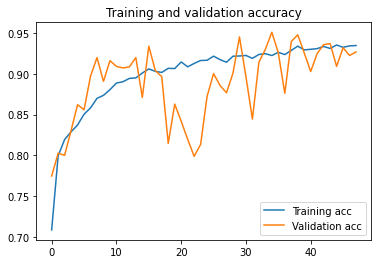

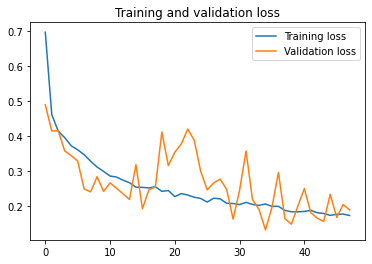

              precision    recall  f1-score   support

        NiCT       0.99      0.90      0.94      1194
         nCT       0.98      0.91      0.94      1933
         pCT       0.75      0.99      0.85       810

    accuracy                           0.92      3937
   macro avg       0.91      0.93      0.91      3937
weighted avg       0.94      0.92      0.92      3937



In [12]:
## Your code begins here

# Model1 Evaluation
# Plot the training and validation accuracy and loss
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction on test dataset Accuracy using classification_report
predictions = model1.predict(x=testX, batch_size=128)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# Save model to directory (Please use the API if you want to enter your own directory to save the models to)
model1.save("C:/Users/fadyn/Desktop/Penn_State_Coursework/SPRING_2021/Deep_Learning/Project/Final/model1", save_format="h5")

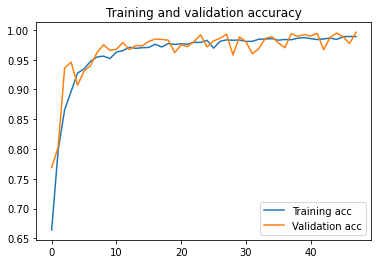

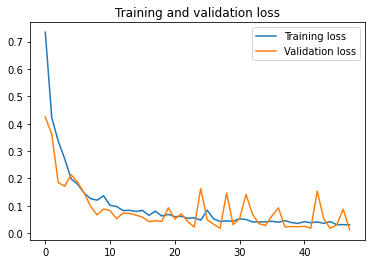

              precision    recall  f1-score   support

        NiCT       0.99      0.99      0.99      1194
         nCT       0.99      1.00      1.00      1933
         pCT       0.99      0.99      0.99       810

    accuracy                           0.99      3937
   macro avg       0.99      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [13]:
## Your code begins here

# Model2 Evaluation
# Plot the training and validation accuracy and loss
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction on test dataset Accuracy using classification_report
predictions = model2.predict(x=testX, batch_size=128)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# Save model to directory (Please use the API if you want to enter your own directory to save the models to)
model2.save("C:/Users/fadyn/Desktop/Penn_State_Coursework/SPRING_2021/Deep_Learning/Project/Final/model2", save_format="h5")

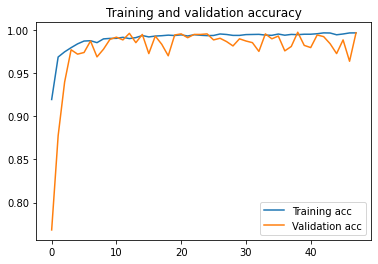

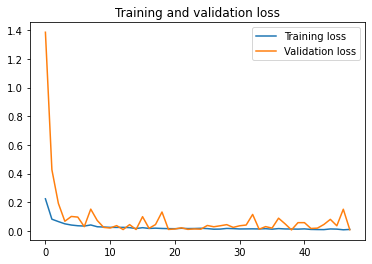

              precision    recall  f1-score   support

        NiCT       1.00      0.98      0.99      1194
         nCT       0.99      1.00      1.00      1933
         pCT       1.00      1.00      1.00       810

    accuracy                           0.99      3937
   macro avg       0.99      0.99      0.99      3937
weighted avg       0.99      0.99      0.99      3937



In [14]:
## Your code begins here

# Model3 Evaluation
# Plot the training and validation accuracy and loss
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction on test dataset Accuracy using classification_report
predictions = model3.predict(x=testX, batch_size=128)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

# Save model to directory (Please use the API if you want to enter your own directory to save the models to)
model3.save("C:/Users/fadyn/Desktop/Penn_State_Coursework/SPRING_2021/Deep_Learning/Project/Final/model3", save_format="h5")

###  References
   * [1] Wang et al. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. https://nihcc.app.box.com/v/ChestXray-NIHCC/file/256057377774
   * [2] Cohen et al. Chester: A Web Delivered Locally Computed Chest X-ray Disease Prediction System. 2020. Proceedings of Machine Learning Research – Under Review:1–12, 2020

   * [3] Wang et al. COVID‑Net: a tailored deep convolutional neural network design for detection of COVID‑19 cases from chest X‑ray images. (2020) 10:19549. https://doi.org/10.1038/s41598-020-76550-z

   * [4] Tuan D. Pham. Classifcation of COVID-19 chest X-rays with deep learning: new models or fine tuning? 2021. https://doi.org/10.1007/s13755-020-00135-3

   * [5] Tartaglione et al. Unveiling COVID-19 from CHEST X-Ray with Deep Learning: A Hurdles Race with Small Data. Int. J. Environ. Res. Public Health 2020, 17, 6933. doi:10.3390/ijerph17186933

   * [6] Wang et al. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. https://nihcc.app.box.com/v/ChestXray-NIHCC/file/256057377774
	

### Credits

    Part of this code are based on:
    * The CNN building tutorial provided by Adrian Rosebrock (https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/)
    * The courses provided by Dr. Youakim Badr in his Deep Learning (DAAN 570) course at Penn State University

In [ ]:
# End of Project